In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.io import loadmat
import matplotlib.pyplot as plt
from utiles import *

In [2]:
target = data_loader("data/lfwcrop_grey", shape=(64, 64))

In [3]:
# Seteamos el % de ruido que queremos
n_ratio = .1
# Agregamos ruido con una distribución normal a las imágenes
data = target + n_ratio*np.random.normal(0, 1, target.shape)
# Con "clip" nos aseguramos de que los valores no esten por arriba de 1 (blanco) ni por debajo de 0 (negro)
data = np.clip(data, a_max=1, a_min=0)

x_train, x_test, y_train, y_test = train_test_split( data, target, test_size=.25, random_state=15)

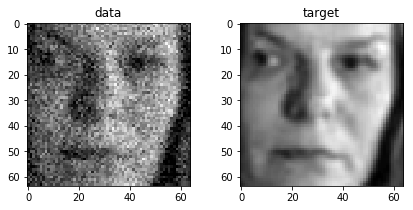

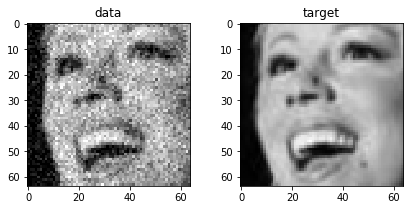

In [4]:
plot_n_faces(x_train, y_train, n=2)

In [5]:
from keras.layers import Conv2D, SeparableConv2D, MaxPooling2D, UpSampling2D, Dense, Reshape, Concatenate, Flatten
from keras.models import Sequential

Using TensorFlow backend.


## Model

In [6]:
## encoder part
model = Sequential()
model.add( Reshape( (64, 64, 1), input_shape=(64, 64) ) )
model.add( Conv2D(filters=1, kernel_size=5, activation="relu", padding="same") )
model.add( Conv2D(filters=10, kernel_size=5, activation="relu", padding="same") )
model.add( MaxPooling2D(2) )
model.add( Conv2D(filters=20, kernel_size=3, activation="relu", padding="same") )
model.add( MaxPooling2D(2) )

## decoder part
model.add( Conv2D(filters=40, kernel_size=3, activation="relu", padding="same") )

model.add( UpSampling2D(2) )
model.add( Conv2D(filters=20, kernel_size=3, activation="relu", padding="same") )
model.add( UpSampling2D(2) )
model.add( Conv2D(filters=10, kernel_size=5, activation="relu", padding="same") )
model.add( Conv2D(filters=1, kernel_size=3, activation="tanh", padding="same") )
model.add( Reshape( (64, 64), input_shape=(64, 64, 1)))

In [8]:
model = Sequential()

model.add( Reshape( (64, 64, 1), input_shape=(64, 64) ))
model.add( Conv2D( filters=16, kernel_size=5, activation="relu", padding="same") )
model.add( MaxPooling2D( 2 ))
model.add( Conv2D( filters=32, kernel_size=3, activation="relu", padding="same") )
model.add( MaxPooling2D( 2 ))
model.add( Conv2D( filters=64, kernel_size=3, activation="relu", padding="same") )
model.add( MaxPooling2D( 2 ))

model.add( Conv2D( filters=128, kernel_size=3, activation="relu", padding="same") )
model.add( UpSampling2D( 2 ))

model.add( Conv2D( filters=64, kernel_size=3, activation="relu", padding="same") )
model.add( UpSampling2D( 2 ))
model.add( Conv2D( filters=32, kernel_size=3, activation="relu", padding="same") )
model.add( UpSampling2D( 2 ))
model.add( Conv2D( filters=16, kernel_size=3, activation="relu", padding="same") )
model.add( Conv2D( filters=1, kernel_size=3, activation="tanh", padding="same") )

model.add( Reshape( (64, 64), input_shape=(64, 64, 1) ) )

In [9]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_3 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 64, 64, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 8, 8, 64)          0         
__________

In [10]:
model.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [12]:
history = model.fit(x_train, y_train,
                    epochs=20,
                    verbose=1,
                    batch_size=100,
                    validation_split=.2)

Train on 7939 samples, validate on 1985 samples
Epoch 1/20
7939/7939 [==============================] - 174s 22ms/step - loss: 0.0207 - mean_absolute_error: 0.1046 - val_loss: 0.0076 - val_mean_absolute_error: 0.0644
Epoch 2/20
7939/7939 [==============================] - 177s 22ms/step - loss: 0.0059 - mean_absolute_error: 0.0562 - val_loss: 0.0047 - val_mean_absolute_error: 0.0495
Epoch 3/20
7939/7939 [==============================] - 178s 22ms/step - loss: 0.0045 - mean_absolute_error: 0.0489 - val_loss: 0.0040 - val_mean_absolute_error: 0.0458
Epoch 4/20
7939/7939 [==============================] - 176s 22ms/step - loss: 0.0037 - mean_absolute_error: 0.0445 - val_loss: 0.0039 - val_mean_absolute_error: 0.0462
Epoch 5/20
7939/7939 [==============================] - 177s 22ms/step - loss: 0.0034 - mean_absolute_error: 0.0425 - val_loss: 0.0032 - val_mean_absolute_error: 0.0409
Epoch 6/20
7939/7939 [==============================] - 178s 22ms/step - loss: 0.0032 - mean_absolute_error

model.save_weights("pesos/k_dae_conv.h5")

In [8]:
model.load_weights("pesos/k_dae_conv.h5")

In [13]:
print( model.evaluate( x_test[:100], y_test[:100], batch_size=100 ) )
p = model.predict( x_test[:100] )

100/100 [==============================] - 1s 6ms/step
[0.0021712298039346933, 0.03434666991233826]


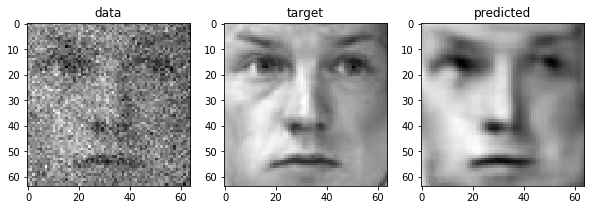

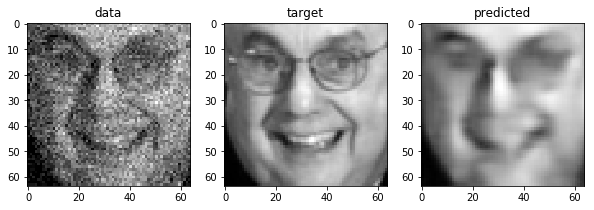

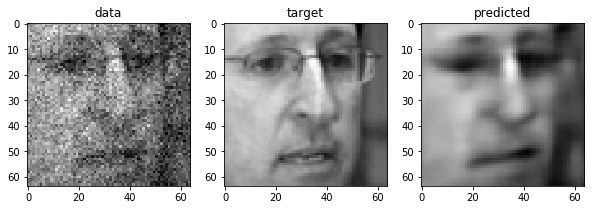

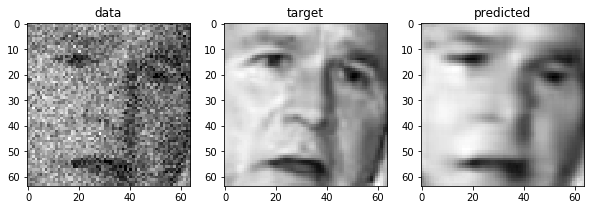

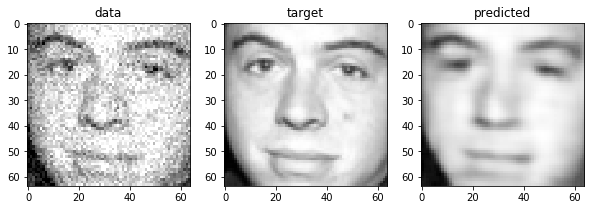

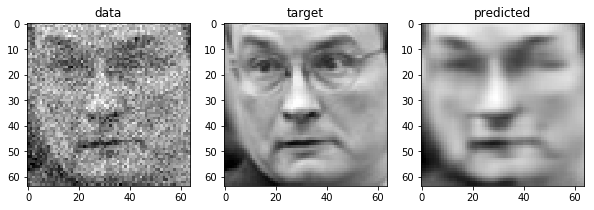

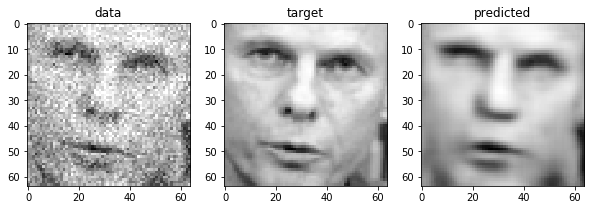

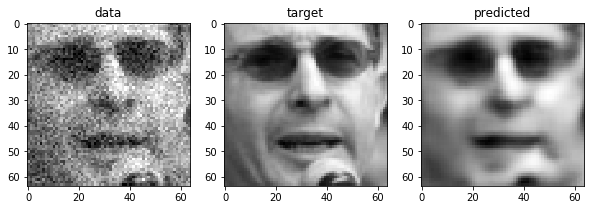

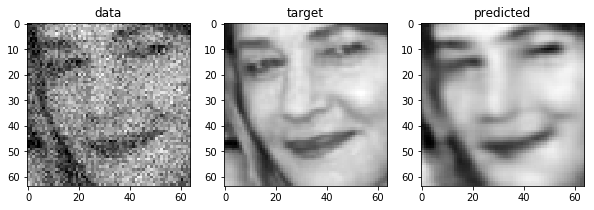

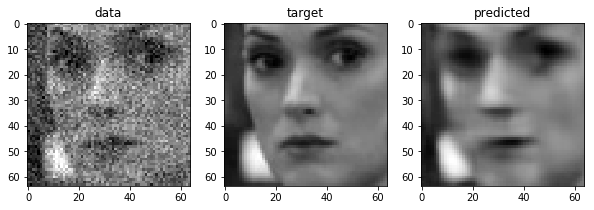

In [14]:
plot_n_faces(x_test[:100], y_test[:100], predicted=p, n=10)

## Modelo 2 (con menos reduccion)

In [18]:
## encoder part
model_2 = Sequential()
model_2.add( Reshape( (64, 64, 1), input_shape=(64, 64) ) )
model_2.add( Conv2D(filters=1, kernel_size=5, activation="relu", padding="same") )
model_2.add( Conv2D(filters=10, kernel_size=5, activation="relu", padding="same") )
model_2.add( MaxPooling2D(2) )
model_2.add( Conv2D(filters=20, kernel_size=3, activation="relu", padding="same") )
model_2.add( MaxPooling2D(2) )

## decoder part
model_2.add( Conv2D(filters=40, kernel_size=3, activation="relu", padding="same") )

model_2.add( UpSampling2D(2) )
model_2.add( Conv2D(filters=20, kernel_size=3, activation="relu", padding="same") )
model_2.add( UpSampling2D(2) )
model_2.add( Conv2D(filters=10, kernel_size=5, activation="relu", padding="same") )
model_2.add( Conv2D(filters=1, kernel_size=3, activation="tanh", padding="same") )
model_2.add( Reshape( (64, 64), input_shape=(64, 64, 1)))

In [19]:
model_2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_7 (Reshape)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 64, 64, 1)         26        
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 64, 64, 10)        260       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 32, 32, 10)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 32, 32, 20)        1820      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 16, 16, 20)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 16, 16, 40)        7240      
__________

In [20]:
model_2.compile(loss="mse", optimizer="adam", metrics=["mae"])

In [ ]:
model_2.load_weights("pesos/k_dae2_conv.h5")

In [56]:
history_2 = model_2.fit(x_train, y_train,
                    epochs=10,
                    verbose=1,
                    batch_size=50,
                    validation_split=.2)

Train on 7939 samples, validate on 1985 samples
Epoch 1/10
7939/7939 [==============================] - 179s 23ms/step - loss: 0.0017 - mean_absolute_error: 0.0302 - val_loss: 0.0016 - val_mean_absolute_error: 0.0299
Epoch 2/10
7939/7939 [==============================] - 190s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0302 - val_loss: 0.0018 - val_mean_absolute_error: 0.0316
Epoch 3/10
7939/7939 [==============================] - 189s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0299 - val_loss: 0.0016 - val_mean_absolute_error: 0.0298
Epoch 4/10
7939/7939 [==============================] - 198s 25ms/step - loss: 0.0016 - mean_absolute_error: 0.0295 - val_loss: 0.0016 - val_mean_absolute_error: 0.0293
Epoch 5/10
7939/7939 [==============================] - 189s 24ms/step - loss: 0.0016 - mean_absolute_error: 0.0298 - val_loss: 0.0017 - val_mean_absolute_error: 0.0309
Epoch 6/10
7939/7939 [==============================] - 198s 25ms/step - loss: 0.0015 - mean_absolute_error

In [57]:
model_2.save_weights("pesos/k_dae2_conv.h5")

In [70]:
print( model_2.evaluate( x_test, y_test, batch_size=100 ) )
p = model_2.predict( x_test )

3309/3309 [==============================] - 30s 9ms/step
[0.0014481807745239973, 0.028256372787029083]


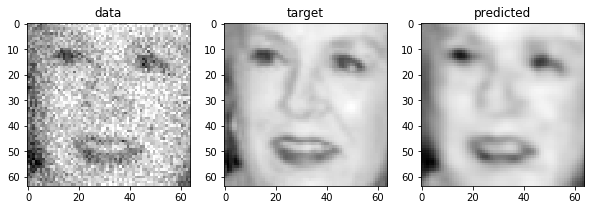

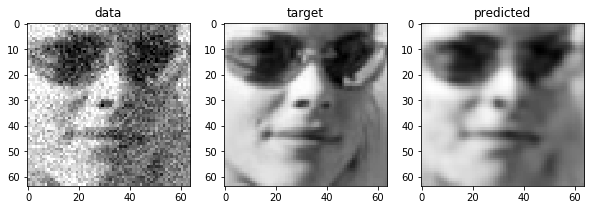

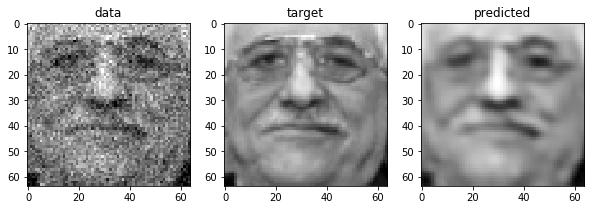

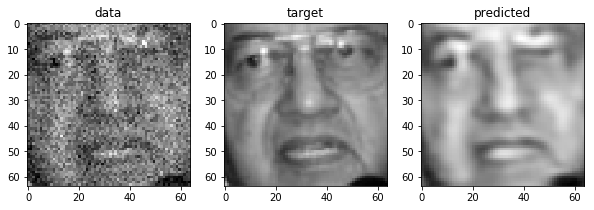

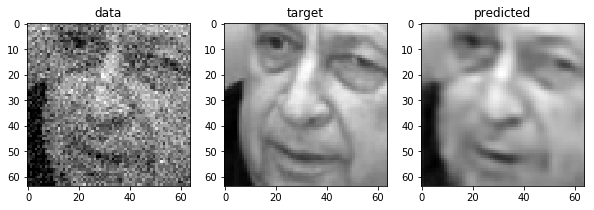

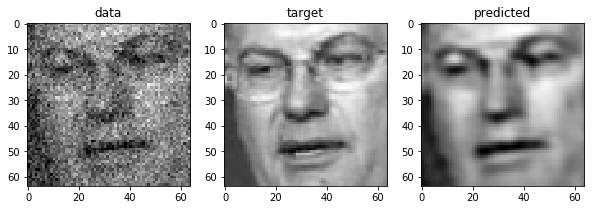

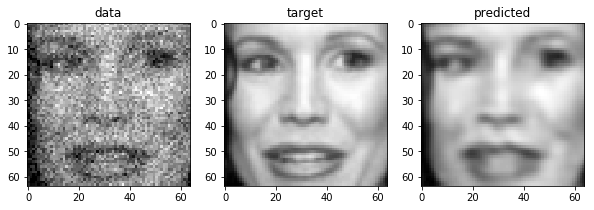

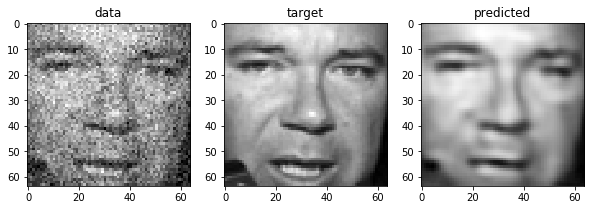

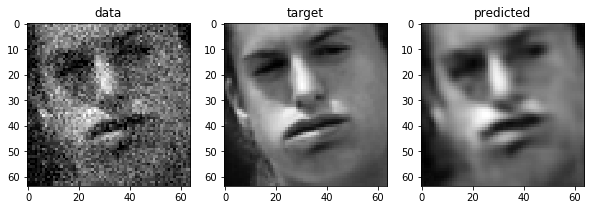

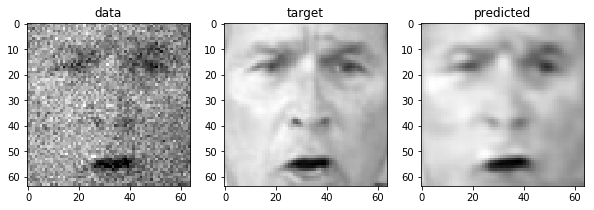

In [71]:
plot_n_faces(x_test, y_test, predicted=p, n=10)

### No es la gran cosa... y si en vez de todo este lio utilizaramos un filtro normal como se vería?

/usr/lib/python3.6/site-packages/skimage/util/dtype.py:122: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


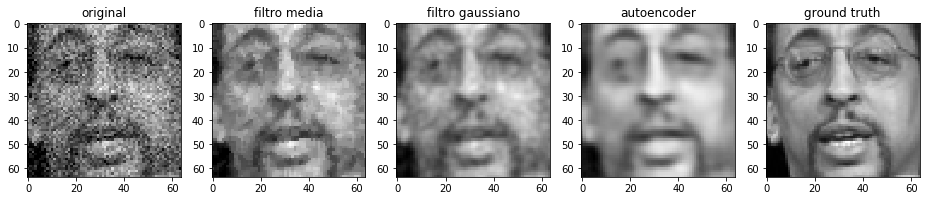

In [79]:
# Aplicamos un filtros media y gaussiano
from skimage.filters import median, gaussian
from skimage.morphology import selem
s = selem.square(3)
i = np.random.randint(x_test.shape[0])
img_m = median( x_test[i], s )
img_g = gaussian( x_test[i] )

cols = 5
titulos = ["original", "filtro media", "filtro gaussiano", "autoencoder", "ground truth"]
imagenes = [x_test[i], img_m, img_g, p[i], y_test[i]]

f = plt.figure(figsize=(16, 3))
for j, (im, t) in enumerate(zip(imagenes, titulos)):
    ax = f.add_subplot(1, cols, j+1)
    ax.set_title(t)
    ax.imshow(im, cmap=plt.cm.gray)
plt.show()

Bueno... no es la gran cosa peeeeero... puede funcionar
(Para este resultado, solo se entrenó a la red durante 30 epochs)